In [18]:
!py -3.8 -m pip install numpy

  Using cached https://files.pythonhosted.org/packages/69/65/0d47953afa0ad569d12de5f65d964321c208492064c38fe3b0b9744f8d44/numpy-1.24.4-cp38-cp38-win_amd64.whl


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [20]:
import trading_strategy
import torch
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

ImportError: 

IMPORTANT: PLEASE READ THIS FOR ADVICE ON HOW TO SOLVE THIS ISSUE!

Importing the numpy C-extensions failed. This error can happen for
many reasons, often due to issues with your setup or how NumPy was
installed.

We have compiled some common reasons and troubleshooting tips at:

    https://numpy.org/devdocs/user/troubleshooting-importerror.html

Please note and check the following:

  * The Python version is: Python3.11 from "c:\Users\gecre\OneDrive\Polytechnique\MAP\EA\github\SigTrading\.venv\Scripts\python.exe"
  * The NumPy version is: "1.24.4"

and make sure that they are the versions you expect.
Please carefully study the documentation linked above for further help.

Original error was: No module named 'numpy.core._multiarray_umath'


In [2]:
# depth = 2
# delta = 0.3
# ts = trading_strategy.TradingStrategy(depth, delta)
# batch_size = 2
# d = 3 # number of stocks
# N = 1 # size of info
# Z_dim = N+d+1 # dimension of Z
# T = 7 # number of time steps
# batch_stock_data = 1+torch.rand(batch_size, T, d) # X
# batch_info_data = 1+torch.rand(batch_size, T, N) # f
# ts.fit(batch_stock_data, batch_info_data)

In [2]:
# Define parameters
sigma_x = 0.2
sigma_y = 0.3
kappa = 0.5
X_0=100
Y_0=100

def synthetic_pairs(batch_size: int, T: int):
    n_assets = 2
    price_paths = torch.zeros(batch_size, T, n_assets)
    
    price_paths[:,:,0] = X_0
    price_paths[:,:,1] = Y_0
    delta_t = 1/T

    for t in range(1,T):
        # price_paths[:,t,0] = price_paths[:,t-1,0] + sigma_x*price_paths[:,t-1,0]*torch.randn(batch_size)*np.sqrt(delta_t)
        price_paths[:,t,0] = price_paths[:,t-1,0] + sigma_x*torch.randn(batch_size)*np.sqrt(delta_t)
        # price_paths[:,t,1] = price_paths[:,t-1,1] + kappa*(price_paths[:,t-1,0]-price_paths[:,t-1,1])*delta_t + sigma_y*price_paths[:,t-1,1]*torch.randn(batch_size)*np.sqrt(delta_t)
    price_paths[:,t,1] = price_paths[:,t-1,1] + kappa*(price_paths[:,t-1,0]-price_paths[:,t-1,1])*delta_t + sigma_y*torch.randn(batch_size)*np.sqrt(delta_t)

    return price_paths

In [4]:
depth = 3
delta = 0.3
ts = trading_strategy.TradingStrategy(depth, delta)
batch_size = 100
T = 1000 # number of time steps
synthetic_batch_stock_data = synthetic_pairs(batch_size, T)
info_data = torch.zeros(batch_size, T, 0) # no info
ts.fit(synthetic_batch_stock_data, info_data)

function compute_signature took 564.03s
mu_sig successfully computed
sigma_sig successfully computed
function compute_sigma_sig took 5.71s
lambda successfully computed
Fitting successful.



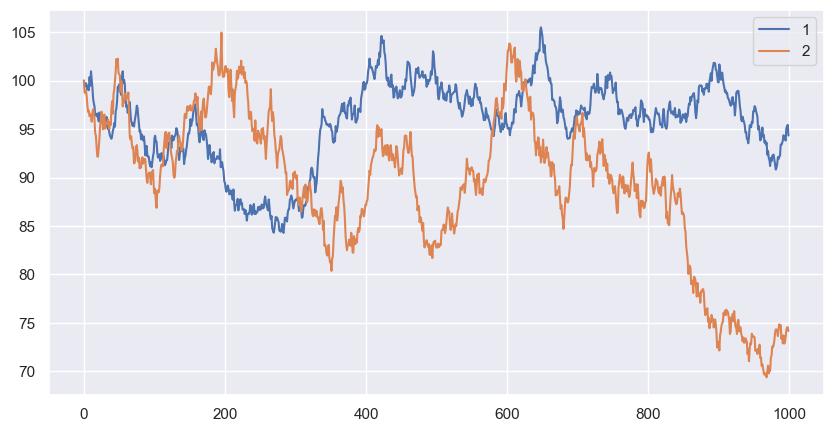

In [9]:
plt.figure(figsize=(10,5))
example_pair_path = synthetic_batch_stock_data[20]
plt.plot(example_pair_path[:,0], label='1')
plt.plot(example_pair_path[:,1], label='2')
plt.legend()
plt.show()

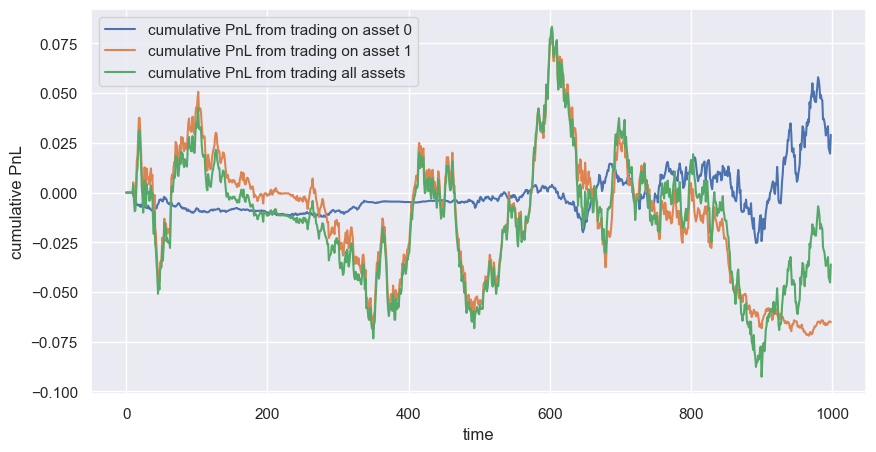

In [10]:
seen_stock_data = synthetic_batch_stock_data[20]
seen_info = info_data[20]
# let's trade on the first path
xi = ts.trade(seen_stock_data, seen_info, min_steps=10)
daily_pnl = ts.compute_pnl(seen_stock_data, xi)
cum_pnl = torch.cumsum(daily_pnl, dim=0)
utils.plot_cum_pnl(cum_pnl)